In [1]:
print('Spaghetti!')

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

!python --version
import tensorflow as tf
print("Num GPUs Available", len(tf.config.experimental.list_physical_devices('GPU')))

print(tf.reduce_sum(tf.random.normal([1000, 1000])))

Spaghetti!
Python 3.7.11
Num GPUs Available 0
tf.Tensor(-105.06503, shape=(), dtype=float32)


In [2]:
#####################################################
# Load the training images
#####################################################

# Load the training images and class labels
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

IMG_SIZE = 299  # VGG16 224, InceptionV3 299
BATCH_SIZE = 10
EPOCHS = 15

# Classes which should be removed from the training set
REMOVE_LABELS = ['20'] #['28', '55']

# Filter for a subset of labels in the images to load
FILTER_LABEL = []

QUICK_DIRTY = True
if QUICK_DIRTY:
    IMG_SIZE = 112
    BATCH_SIZE = 40
    EPOCHS = 10
    #Below are the 5 most unrepresented classes and the 5 most represented classes
    FILTER_LABEL = [] 
    #27, 255, 257, 274, 278, 489, 490, 491, 494, 525
    #FILTER_LABEL = ['1','2','3','4','5','6','7','8','9','10']

# Local data directories
DATA_DIR = 'C:\Data\DS_Data\AML_Kaggle'
TRAIN_DIR = DATA_DIR + '/train_set/'
TEST_DIR = DATA_DIR + '/test_set/'
MODEL_DIR = DATA_DIR + '/models/'

# Maximum number of images to load (there are 30k), set to 0 for all
MAX_IMAGE = 0

# Load all the training labels
train_labels = pd.read_csv(DATA_DIR + '/train_labels.csv', dtype={'label': object})
if (len(FILTER_LABEL) > 0):
    train_labels = train_labels[train_labels['label'].isin(FILTER_LABEL)].copy().reset_index()

# Remove bad classes from the training data
count = len(train_labels)
train_labels = train_labels[~train_labels['label'].isin(REMOVE_LABELS)]
print('Removed {} bad training samples'.format(count - len(train_labels)))
NUM_CLASSES = len(train_labels.groupby('label').count())

# Remove images with text from the training data
#images_with_text = pd.read_csv('./images_with_text.csv')
#count = len(train_labels)
#train_labels = train_labels[~train_labels['img_name'].isin(images_with_text['img_name'])]
print('Removed {} training samples with text'.format(count - len(train_labels)))
NUM_CLASSES = len(train_labels.groupby('label').count())

# Shuffle the training labels
train_labels = shuffle(train_labels, random_state=3422545)

print('{} training labels loaded'.format(len(train_labels)))  

Removed 27 bad training samples
Removed 27 training samples with text
30585 training labels loaded


In [3]:
#####################################################
# Create the data generators
#####################################################

import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import adam
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import datetime
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Create a training and test set generator
train_datagen = ImageDataGenerator(
        rotation_range=10,#40
        width_shift_range=0.1,#0.2
        height_shift_range=0.1,#0.2
        rescale=1./255,
        shear_range=0.1, #0.2
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_split = int(len(train_labels)*0.8)
train_dataframe = train_labels[:train_split][['img_name','label']]
val_dataframe = train_labels[train_split:][['img_name','label']]

train_generator = train_datagen.flow_from_dataframe(
    train_dataframe,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_dataframe,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False)

# Early stopping callback, stops the training if there's no more progress
early_stopping = EarlyStopping(
    monitor='val_acc', 
    patience=3, 
    min_delta=0.001, 
    mode='max'
)

# Learning rate scheduler callback, decreases the LR during training
def lr_scheduler(epoch, lr):
    if epoch == 3:
        lr = lr/10       # After 3 epochs, divide by 10
    
    if epoch == 6:
        return lr/10

    if epoch == 10:
        return lr/10
        
    return lr

lr_scheduler_callback = LearningRateScheduler(
    lr_scheduler
)

# Model checkpoint callback, stores the model every few epochs during training
model_checkpoint_callback = ModelCheckpoint(
    MODEL_DIR + 'model_checkpoint',
    monitor="val_acc",
    verbose=1,
    save_weights_only=False,
    mode="auto"#,
    #save_freq="epoch"
)

def plot_hist(hist):
    plt.plot(hist.history["acc"])
    plt.plot(hist.history["val_acc"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

Using TensorFlow backend.


Found 24468 validated image filenames belonging to 79 classes.
Found 6117 validated image filenames belonging to 79 classes.
Found 0 images belonging to 0 classes.


In [4]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(train_dataframe['label']),
                                                 y = train_dataframe['label'])
class_weights = dict(zip(np.unique(train_dataframe['label']), class_weights))
class_weights


real_weights = {}
i = 0
for num in np.unique(train_dataframe['label']):
    real_weights[i] = class_weights[str(num)]
    i+=1

real_weights

{0: 0.8393537099927961,
 1: 0.84623365843536,
 2: 0.9832429174201326,
 3: 0.9385500575373993,
 4: 1.352495716101929,
 5: 0.8579543462253235,
 6: 0.8172071741090812,
 7: 0.9529892891918208,
 8: 0.8303525978212916,
 9: 1.1821432022417624,
 10: 1.329276905525072,
 11: 0.9163358549921354,
 12: 1.1386820551005212,
 13: 1.0754219409282701,
 14: 0.8193690978501105,
 15: 0.9739670408406974,
 16: 1.1687604490088368,
 17: 0.9273099370878496,
 18: 1.098303258820361,
 19: 1.243861522037517,
 20: 0.8874542091327845,
 21: 0.950066009163625,
 22: 0.8555843065948667,
 23: 1.1471167369901547,
 24: 1.1958359806461072,
 25: 1.1386820551005212,
 26: 1.0829423740816146,
 27: 1.14288383390163,
 28: 0.8823974899924267,
 29: 0.8003140025512707,
 30: 0.7801549596658482,
 31: 1.0534745543787134,
 32: 1.0121618267560188,
 33: 1.3888857353692456,
 34: 1.0499034541943788,
 35: 1.5409030795390137,
 36: 0.9442729237418956,
 37: 1.0606901335182937,
 38: 1.0255679436666947,
 39: 0.8900043649061545,
 40: 1.049903454194

In [5]:
train_generator

Epoch 1/10
305/305 [==============================] - 1693s 6s/step - loss: 3.8362 - acc: 0.1424 - val_loss: 2.9803 - val_acc: 0.2829
Epoch 2/10
305/305 [==============================] - 1701s 6s/step - loss: 2.7078 - acc: 0.3407 - val_loss: 2.3935 - val_acc: 0.4053
Epoch 3/10
305/305 [==============================] - 1596s 5s/step - loss: 2.1943 - acc: 0.4484 - val_loss: 2.2270 - val_acc: 0.4500
Epoch 4/10
305/305 [==============================] - 1573s 5s/step - loss: 1.9338 - acc: 0.5041 - val_loss: 2.1505 - val_acc: 0.4734
Epoch 5/10
305/305 [==============================] - 1569s 5s/step - loss: 1.7045 - acc: 0.5562 - val_loss: 2.0567 - val_acc: 0.4961
Epoch 6/10
305/305 [==============================] - 1568s 5s/step - loss: 1.5228 - acc: 0.6025 - val_loss: 2.0950 - val_acc: 0.5079
Epoch 7/10
305/305 [==============================] - 1558s 5s/step - loss: 1.3775 - acc: 0.6330 - val_loss: 2.1349 - val_acc: 0.4990
Epoch 8/10
305/305 [==============================] - 1560s 5s

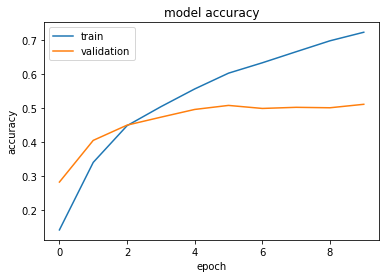

In [6]:
##################################################
# Train Xception model
##################################################
 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam

# Define Tensorboard callback with dedicated log directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, update_freq=1)

def InitializeXceptionModel():
    # Defining the pretrained base model
    base = Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE,IMG_SIZE,3))
    x = base.output
    x = GlobalAveragePooling2D()(x)
    # On more dense layers + dropout, didn't improve at all
    #x = Dense(1024, activation="relu")(x) # Adding dense 512 + dropout lowered to 59%
    #x = Dropout(0.1)(x)
    # Defining the head of the model where the prediction is conducted
    head = Dense(NUM_CLASSES, activation='softmax')(x)
    # Combining base and head 
    model = Model(inputs=base.input, outputs=head)

    return model

if 'model' in locals() or 'model' in globals():
    if input('Train a fresh model?') == 'y':
        print('Discarding current model')
        model = InitializeXceptionModel()
else:
    model = InitializeXceptionModel()

# Compiling the model
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics=['acc'])

#class_weights = {
#    #0 : 113.3778, 
#    0 : 12.00471,
#    1 : 11.91128,
#    2 : 11.17226,
#    3 : 11.01151,
#    4 : 10.77887324,
#    5 : 6.260123,
#    6 : 6.247347,
#    7 : 6.234623,
#    8 : 6.196761,
#    9 : 5.830857
#}

#class_weights = {
#    20 : 113.3778, 
#    42 : 12.00471,
#    67 : 11.91128,
#    78 : 11.17226,
#    59 : 11.01151,
#    9 : 6.260123,
#    61 : 6.247347,
#    57 : 6.234623,
#    37 : 6.196761,
#    71 : 5.830857
#}

hist = model.fit(
    train_generator, 
    epochs=EPOCHS, 
    steps_per_epoch=int(len(train_dataframe)/BATCH_SIZE/2), 
    validation_data=val_generator, 
    validation_steps=int(len(val_dataframe)/BATCH_SIZE/2),
    class_weight = real_weights, 
    verbose=1)#,
    #callbacks=[early_stopping, tb_callback, lr_scheduler_callback, model_checkpoint_callback])

plot_hist(hist)

In [ ]:
##################################################
# Train InceptionV3 model 
##################################################

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from PIL import Image
import datetime

# Define Tensorboard callback with dedicated log directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = TensorBoard(log_dir=log_dir, update_freq=1)

def InitializeInceptionV3Model():
    pre_trained_model = InceptionV3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top=False, weights = 'imagenet')

    for layer in pre_trained_model.layers: 
        layer.trainable=False

    x = layers.Flatten()(pre_trained_model.output)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = keras.Model(pre_trained_model.input, x)
    return model

if 'model' in locals() or 'model' in globals():
    if input('Train a fresh model?') == 'y':
        print('Discarding current model')
        model = InitializeInceptionV3Model()
else:
    model = InitializeInceptionV3Model()
    
model.compile(
    #optimizer = RMSprop(learning_rate=0.0001), 
    #optimizer = RMSprop(learning_rate=0.00005), 
    optimizer = RMSprop(learning_rate=0.000001), 
    loss='categorical_crossentropy', 
    metrics=['acc'])

hist = model.fit(
    train_generator, 
    epochs=EPOCHS, 
    steps_per_epoch=int(len(train_dataframe)/BATCH_SIZE/4), 
    validation_data=val_generator, 
    validation_steps=int(len(val_dataframe)/BATCH_SIZE/4),
    verbose=1,
    callbacks=[early_stopping, tb_callback])

plot_hist(hist)

In [ ]:
##################################################
# Fine tune InceptionV3 model
##################################################

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.000005, momentum=0.9),
                            loss='categorical_crossentropy',
                            metrics=['acc'])

hist = model.fit(
    train_generator, 
    epochs=EPOCHS, 
    steps_per_epoch=int(len(train_dataframe)/BATCH_SIZE/4), 
    validation_data=val_generator, 
    validation_steps=int(len(val_dataframe)/BATCH_SIZE/4),
    verbose=1,
    callbacks=[early_stopping, tb_callback])                            

plot_hist(hist)

In [ ]:
#######################################################
#  Save the model
#######################################################

# TODO: model name in filename
model.save(MODEL_DIR + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + 
    'model.' + 'xception' +
    '.' + str(NUM_CLASSES) + 'c.' +
    str(IMG_SIZE) + 'px.69p-removed-0-classes.remove-0-ocr')

In [ ]:
#######################################################
#  Load a model
#######################################################
from tensorflow.keras import models

#model = models.load_model(MODEL_DIR + 'model_checkpoint')
model = models.load_model(MODEL_DIR + '20211205-122437model.xception.80c.299px.68p-2-classes-removed')

In [ ]:
#######################################################
#  Classify the test set
#######################################################

# Classify
test_generator.reset()
probabilities = model.predict(test_generator)
filenames = test_generator.filenames.copy()
for i in range(0,len(filenames)):
    filenames[i] = filenames[i][filenames[i].rfind('\\')+1:]
predicted_class_indices = np.argmax(probabilities, axis=-1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# Create the pandas DataFrame
results=pd.DataFrame({"img_name":filenames,
                      "label":predictions})

results.to_csv(DATA_DIR + '/predictions.csv', index=False)
results

In [ ]:
#######################################################
#  Look for confusing training images
#######################################################

train_set_datagen = ImageDataGenerator(rescale=1./255)

train_set_generator = train_set_datagen.flow_from_dataframe(
    train_labels,
    x_col = 'img_name',
    y_col = 'label',
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=100,
    class_mode='categorical',
    shuffle=False
)

# Classify
train_set_generator.reset()
#probabilities = model.predict(train_set_generator, batch_size=32, verbose=1, steps=10, workers=2)
probabilities = model.predict(train_set_generator, verbose=1, workers=2)

In [ ]:
#######################################################
#  Display the confusing training images
#######################################################

from PIL import Image
fig, axs = plt.subplots(ncols=2, nrows=8)
fig.set_size_inches(15, 30)

# Show images that were hard to classify
confidence_threshold = 0.3

filenames = pd.DataFrame({'filename':train_set_generator.filenames.copy()})
hard_images = filenames[np.max(probabilities, axis=1) < confidence_threshold]
print('Found {} confusing training images at a {} confidence threshold'.format(len(hard_images), confidence_threshold))

row = 0
for idx in hard_images.sample(frac=1).index:
    # Load image
    img = Image.open(TRAIN_DIR + hard_images.loc[idx]['filename'])

    # Plot image    
    axs[row, 0].imshow(img)
    #axs[row, 0].set_title('Class: ' + hard_images.loc[idx]['label'])

    # Plot probabilities
    axs[row, 1].plot(probabilities[idx])
    axs[row, 1].set_title('Max:' + str(max(probabilities[idx])))

    #print(label)
    print(hard_images['filename'][idx])

    row += 1
    if row > 7:
        break

In [ ]:
#######################################################
#  Confusion matrix
#######################################################

val_generator.reset()

# Get the ground truth
filenames = val_generator.filenames.copy()
labels = val_generator.labels.copy()

# Predict classes
probabilities = model.predict(val_generator, verbose=1, workers=2)
predictions = np.argmax(probabilities, axis=-1)

df_cm = pd.DataFrame({
    'img_name': filenames,
    'label_truth': labels,
    'label_predict': predictions
    })

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.pyplot import figure

fig, ax = plt.subplots(figsize=(20,20))
cm = confusion_matrix(df_cm['label_truth'], df_cm['label_predict'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax)

In [ ]:
#######################################################
# Show the images of each class to debug bad training
# images
#######################################################

NCOL = 5
NROW = 32

from PIL import Image
fig, axs = plt.subplots(ncols=NCOL, nrows=NROW)
fig.set_size_inches(20, 120)

label = '12'
df = train_labels[train_labels['label'] == label].sample(frac=1)
print('Found {} images for class {}'.format(len(df), label))

i = 0
for row in range(0, NROW):
    if i > len(df):
        print('No more images')
        break

    for col in range(0, NCOL):
        # Load image
        img = Image.open(TRAIN_DIR + df.iloc[i]['img_name'])

        # Plot image    
        axs[row, col].imshow(img)
        axs[row, col].xaxis.set_visible(False)
        axs[row, col].yaxis.set_visible(False)
        axs[row, col].set_title('Class: ' + df.iloc[i]['img_name'])

        i += 1

In [ ]:
#######################################################
#  Check which classes have the most problems - part 1
#######################################################

# Predict classes
val_generator.reset()
probabilities = model.predict(val_generator, verbose=1)
predicted_label_indices = np.argmax(probabilities, axis=-1)

# Get the ground truth
filenames = val_generator.filenames.copy()
truth_label_indices = val_generator.labels.copy()

label_dict = (train_generator.class_indices)
label_dict = dict((v,k) for k,v in label_dict.items())
y_pred = [label_dict[k] for k in predicted_label_indices]
y_truth = [label_dict[k] for k in truth_label_indices]

In [ ]:
#######################################################
#  Check which classes have the most problems - part 2
#######################################################

df_cm = pd.DataFrame({
    'img_name': filenames,
    'label_truth': y_truth,
    'label_predict': y_pred
    })
    
df_cm['correct'] = False
df_cm.loc[df_cm['label_truth'] == df_cm['label_predict'], 'correct'] = True
print(len(df_cm[df_cm['correct'] == True]))
print(len(df_cm[df_cm['correct'] == False]))

plt.figure(figsize=(15, 10))
class_report_mean = df_cm.groupby('label_truth').mean()['correct']
class_report_count = df_cm.groupby('label_truth').count()['img_name']
#class_report.plot()
class_report = pd.DataFrame({
    'count': class_report_count,
    'correct': class_report_mean
    })
class_report.sort_values('correct', inplace=True)
class_report['correct'].plot()
print(class_report[:10])